In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large',
          'figure.facecolor': 'w'}
plt.rcParams.update(params)

In [3]:
def get_sb_moffat(r, alpha, beta):
    """
    Calculate the surface brightness of light at radius r of a Moffat profile.
    The integral (i.e., total flux) is unity by definition.
    """
    i = (beta-1)/(np.pi * alpha**2)*(1 + (r/alpha)**2)**(-beta)
    return i

In [4]:
ccd_columns = ['image_filename', 'expnum', 'ccdname', 'filter']
cat = Table(fitsio.read('/global/cfs/cdirs/cosmo/work/legacysurvey/dr10/survey-ccds-dr10-v4.fits', columns=ccd_columns))
cat['ccd_id_str'] = np.char.add(np.array(cat['expnum']).astype(str), cat['ccdname'])
print(len(cat))

psfex = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/dr10dev/misc/survey-ccds-dr10-v4-psfex-fwhm.fits',))
psfex['ccd_id_str'] = np.char.add(np.array(psfex['expnum']).astype(str), psfex['ccdname'])
mask = psfex['failure']==False
psfex = psfex[mask]
cat = join(cat, psfex[['ccd_id_str', 'psf_fwhm', 'median_psf_fwhm', 'moffat_alpha', 'moffat_beta', 'failure']], keys='ccd_id_str', join_type='inner')
print(len(cat))

dr9 = Table(fitsio.read('/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/survey-ccds-decam-dr9.fits.gz', columns=['expnum', 'ccdname', 'ccd_cuts']))
dr9['ccd_id_str'] = np.char.add(np.array(dr9['expnum']).astype(str), dr9['ccdname'])
print(len(dr9))
mask = dr9['ccd_cuts']==0
dr9 = dr9[mask]
print(len(dr9))

mask = np.in1d(cat['ccd_id_str'], dr9['ccd_id_str'])
cat = cat[mask]
print(len(cat))

cat['psf_fwhm_arcsec'] = cat['psf_fwhm']*0.262

cat.write('/global/cfs/cdirs/desi/users/rongpu/tmp/survey-ccds-psfex-fwhm.fits')

# cat = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/tmp/survey-ccds-psfex-fwhm.fits'))
# cat_all = cat.copy()

15523579
15509917
6388340
4891222
4891203


In [5]:
tmp = Table()
tmp['filter'], tmp['count'] = np.unique(cat['filter'], return_counts=True)
tmp.sort('count')
tmp

filter,count
str1,int64
r,1567927
g,1641473
z,1681803


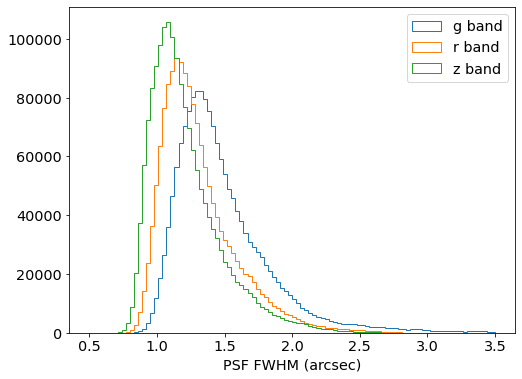

In [6]:
plt.figure(figsize=(8, 6))
for band in ['g', 'r', 'z']:
    mask = cat['filter']==band
    plt.hist(cat['psf_fwhm_arcsec'][mask], 100, histtype='step', label=band+' band', range=(0.5, 3.5))
plt.xlabel('PSF FWHM (arcsec)')
plt.legend()
plt.show()

In [7]:
for band in ['g', 'r', 'z']:
    mask = cat['filter']==band
    print('{} {:.4f} {:4f}'.format(band, cat['psf_fwhm_arcsec'][mask].min(), cat['psf_fwhm_arcsec'][mask].max()))

g 0.8035 4.345668
r 0.7401 3.473294
z 0.6848 4.548400


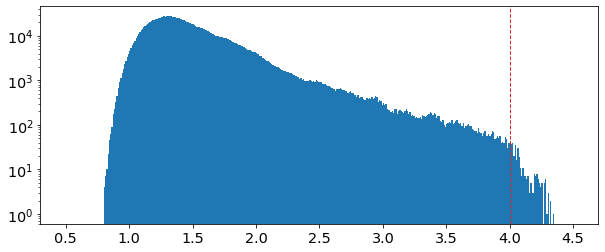

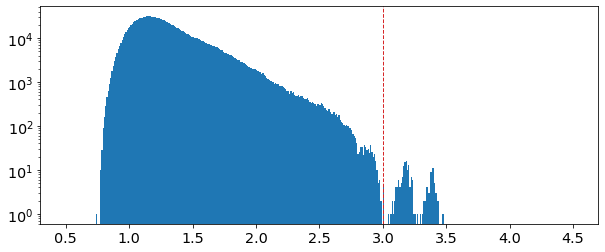

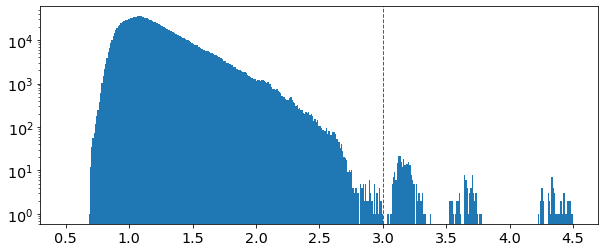

In [8]:
psf_max = {'g': 4.0, 'r': 3.0, 'z': 3.}

for band in ['g', 'r', 'z']:
    mask = cat['filter']==band
    plt.figure(figsize=(10, 4))
    plt.hist(cat['psf_fwhm_arcsec'][mask], 400, range=(0.5, 4.5), log=True)
    plt.axvline(psf_max[band], color='C3', lw=1, ls='--')
    plt.show()

9 9
decam/CP/V4.8.2a/CP20150414/c4d_150415_052546_ooi_g_ls9-psfex.fits
Sum:  0.997 1.006
FWHM: 3.130 2.141


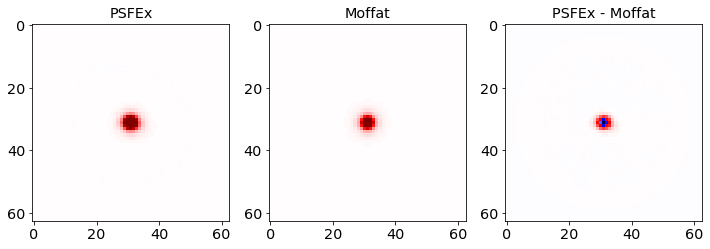

decam/CP/V4.9/CP20150414/c4d_150415_051608_ooi_g_ls9-psfex.fits
Sum:  0.997 1.010
FWHM: 3.184 2.140


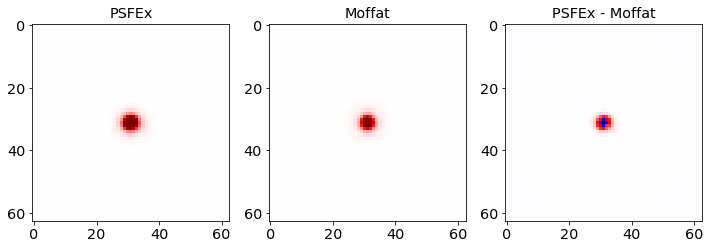

decam/CP/V4.8.2/CP20170326/c4d_170327_065254_ooi_g_ls9-psfex.fits
Sum:  0.997 1.012
FWHM: 3.170 2.417


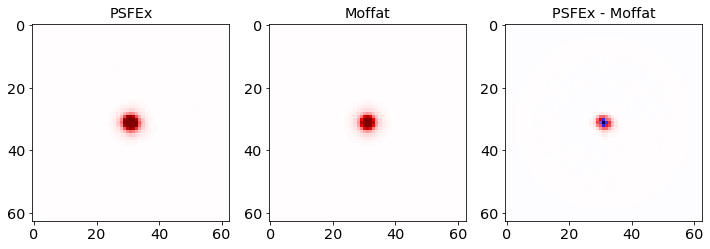

decam/CP/V4.8.2a/CP20150414/c4d_150415_050358_ooi_r_ls9-psfex.fits
Sum:  0.998 1.009
FWHM: 3.056 2.080


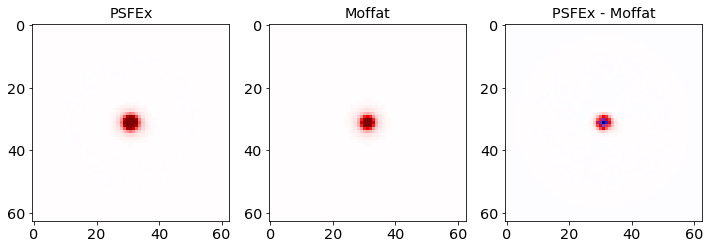

decam/CP/V4.8.2a/CP20150414/c4d_150415_052804_ooi_r_ls9-psfex.fits
Sum:  0.997 1.011
FWHM: 3.057 2.169


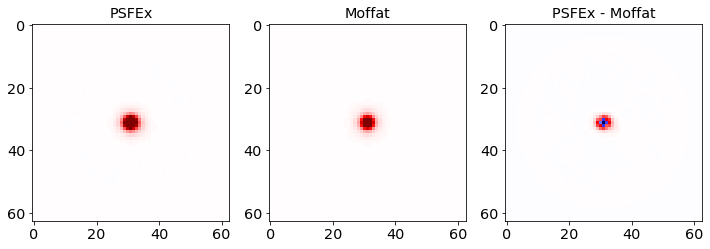

decam/CP/V4.9/CP20180222/c4d_180223_015204_ooi_r_ls9-psfex.fits
Sum:  0.997 1.015
FWHM: 3.087 2.284


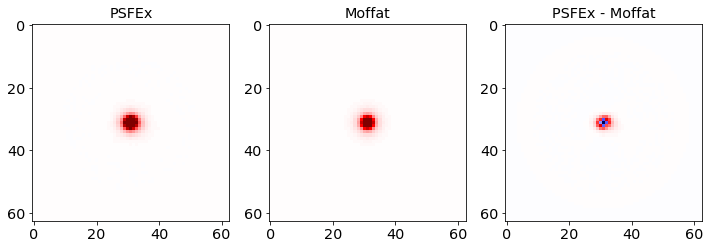

decam/CP/V4.8.2/CP20161105/c4d_161106_010002_ooi_z_ls9-psfex.fits
Sum:  0.997 1.007
FWHM: 2.736 2.165


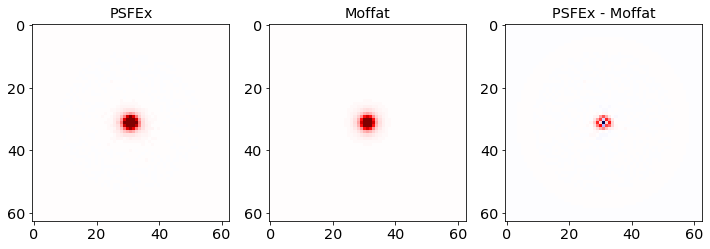

decam/CP/V4.8.2/CP20161105/c4d_161106_004806_ooi_z_ls9-psfex.fits
Sum:  0.997 1.013
FWHM: 2.791 2.217


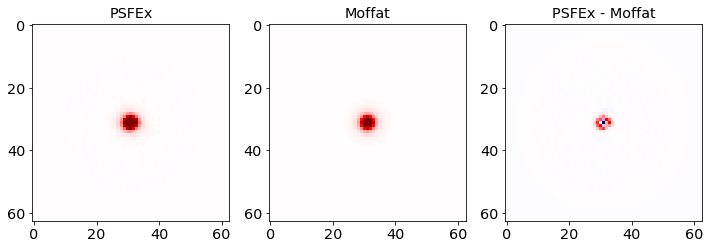

decam/CP/V4.8.2/CP20161105/c4d_161106_004610_ooi_z_ls9-psfex.fits
Sum:  0.997 1.019
FWHM: 2.789 2.133


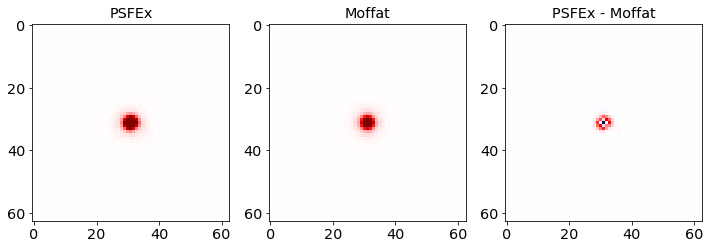

In [10]:
# Plot the best-seeing PSF's

idx = []
for band in ['g', 'r', 'z']:
    mask = cat['filter']==band
    mask &= cat['ccdname']=='N11'
    idx1 = np.where(mask)[0]
    idx1 = idx1[np.argsort(cat['psf_fwhm_arcsec'][mask])[:3]]
    idx.append(idx1)
idx = np.concatenate(idx)
print(len(idx), len(np.unique(cat['expnum'][idx])))

for index in idx:

    image_filename = cat['image_filename'][index]
    psfex_filename = image_filename[:image_filename.find('.fits.fz')]+'-psfex.fits'
    print(psfex_filename)
    psfex_path = os.path.join('/global/cfs/projectdirs/cosmo/work/legacysurvey/dr10/calib/psfex', psfex_filename)
    psfex = Table(fitsio.read(psfex_path))
    ii = np.where(psfex['ccdname']==cat['ccdname'][index])[0][0]
    psfex_img = np.array(psfex['psf_mask'][ii][0])
    psfex_nea = np.sum(psfex_img)**2/np.sum(psfex_img**2)
    psfex_fwhm = np.sqrt(psfex_nea / (4 * np.pi)) * 2.3548  # FWHM a la tractor

    img_size = 31
    pixscale = 0.262

    subpix_factor = 11
    x = pixscale * (np.arange(-img_size-0.5, img_size+0.5, 1/subpix_factor) + 1/subpix_factor/2)
    y = pixscale * (np.arange(-img_size-0.5, img_size+0.5, 1/subpix_factor) + 1/subpix_factor/2)
    xx, yy = np.meshgrid(x, y)
    rr = np.sqrt(xx**2+yy**2)

    alpha, beta = cat['moffat_alpha'][index], cat['moffat_beta'][index]
    moffat_img = pixscale**2 * get_sb_moffat(rr, alpha, beta)
    moffat_img = np.mean(np.mean(moffat_img.reshape((moffat_img.shape[0]//subpix_factor, subpix_factor, moffat_img.shape[1]//subpix_factor,-1)), axis=3), axis=1)
    print('Sum:  {:.3f} {:.3f}'.format(np.sum(moffat_img), np.sum(psfex_img)))
    moffat_nea = np.sum(moffat_img)**2/np.sum(moffat_img**2)
    moffat_fwhm = np.sqrt(moffat_nea / (4 * np.pi)) * 2.3548  # FWHM a la tractor
    print('FWHM: {:.3f} {:.3f}'.format(psfex_fwhm, moffat_fwhm))

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(psfex_img, vmin=-0.02, vmax=0.02, cmap='seismic')
    ax[0].set_title('PSFEx')
    ax[1].imshow(moffat_img, vmin=-0.02, vmax=0.02, cmap='seismic')
    ax[1].set_title('Moffat')
    ax[2].imshow(psfex_img - moffat_img, vmin=-0.02, vmax=0.02, cmap='seismic')
    ax[2].set_title('PSFEx - Moffat')
    plt.show()

9 9
decam/CP/V4.9/CP20170918/c4d_170919_001708_ooi_g_ls9-psfex.fits
Sum:  0.981 1.262
FWHM: 15.793 16.691


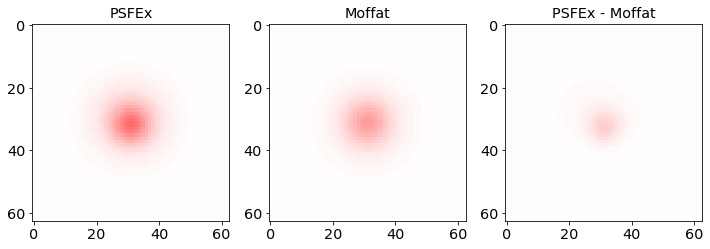

decam/CP/V4.8.2a/CP20161123/c4d_161124_041257_ooi_g_ls9-psfex.fits
Sum:  0.997 1.220
FWHM: 16.026 16.277


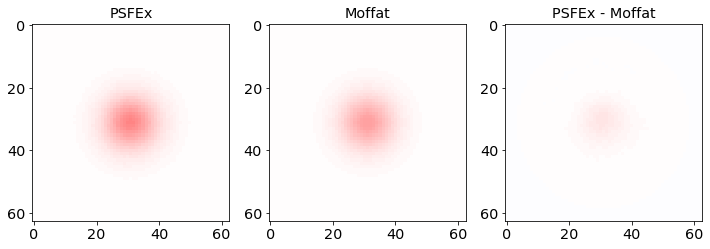

decam/CP/V4.9/CP20161207/c4d_161208_065354_ooi_g_ls9-psfex.fits
Sum:  0.992 1.244
FWHM: 16.104 16.755


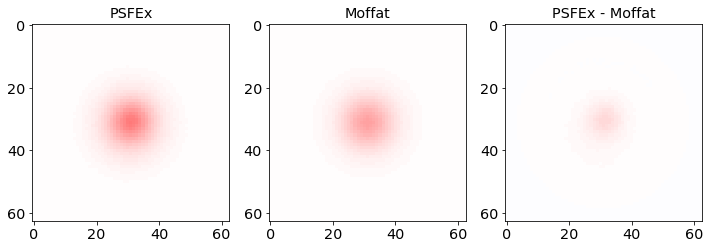

decam/CP/V4.8.2a/CP20160904/c4d_160905_091603_ooi_r_ls9-psfex.fits
Sum:  0.995 1.124
FWHM: 12.590 12.687


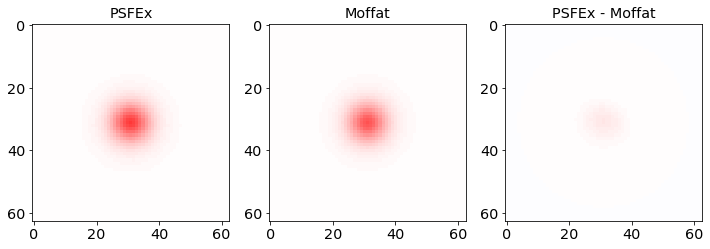

decam/CP/V4.9/CP20171011/c4d_171012_011920_ooi_r_ls9-psfex.fits
Sum:  0.991 1.145
FWHM: 12.836 13.148


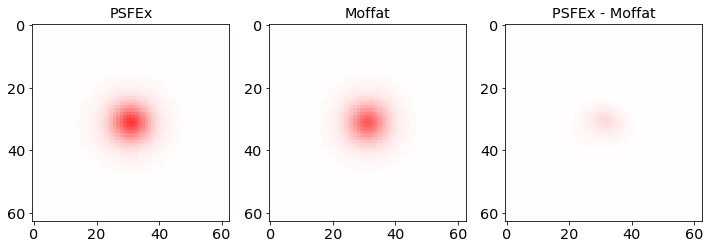

decam/CP/V4.9/CP20171011/c4d_171012_011522_ooi_r_ls9-psfex.fits
Sum:  0.988 1.173
FWHM: 13.581 14.101


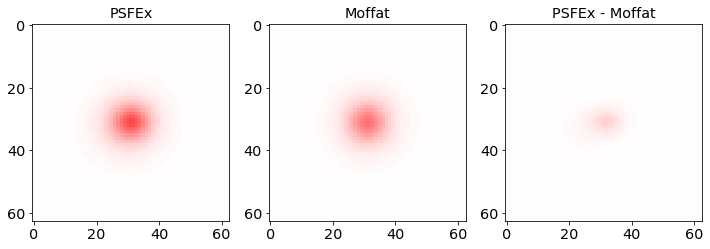

decam/CP/V4.8.2a/CP20160911/c4d_160912_001556_ooi_z_ls9-psfex.fits
Sum:  0.995 1.136
FWHM: 12.986 13.097


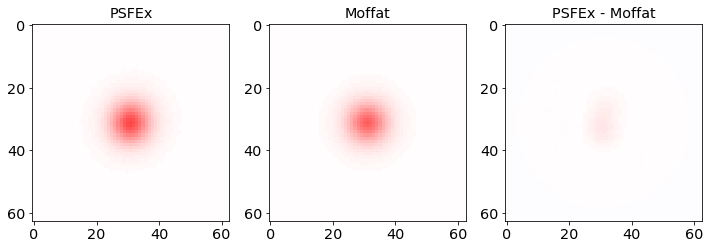

decam/CP/V4.9/CP20171012/c4d_171013_090510_ooi_z_ls9-psfex.fits
Sum:  0.990 1.192
FWHM: 14.386 14.833


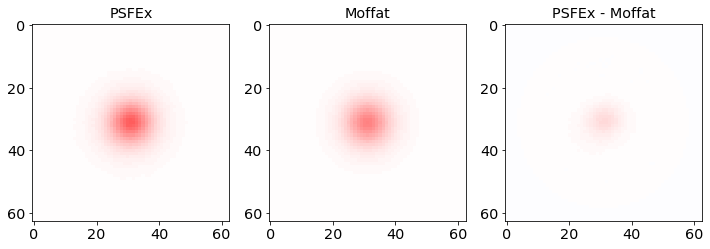

decam/CP/V4.8.2a/CP20160911/c4d_160912_001152_ooi_z_ls9-psfex.fits
Sum:  0.993 1.285
FWHM: 17.046 17.607


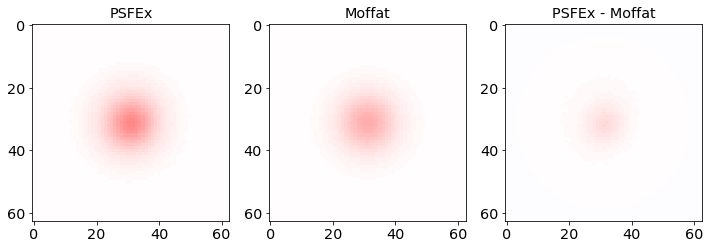

In [11]:
# Plot the worse-seeing PSF's

idx = []
for band in ['g', 'r', 'z']:
    mask = cat['filter']==band
    mask &= cat['ccdname']=='N11'
    idx1 = np.where(mask)[0]
    idx1 = idx1[np.argsort(cat['psf_fwhm_arcsec'][mask])[-3:]]
    idx.append(idx1)
idx = np.concatenate(idx)
print(len(idx), len(np.unique(cat['expnum'][idx])))

for index in idx:

    image_filename = cat['image_filename'][index]
    psfex_filename = image_filename[:image_filename.find('.fits.fz')]+'-psfex.fits'
    print(psfex_filename)
    psfex_path = os.path.join('/global/cfs/projectdirs/cosmo/work/legacysurvey/dr10/calib/psfex', psfex_filename)
    psfex = Table(fitsio.read(psfex_path))
    ii = np.where(psfex['ccdname']==cat['ccdname'][index])[0][0]
    psfex_img = np.array(psfex['psf_mask'][ii][0])
    psfex_nea = np.sum(psfex_img)**2/np.sum(psfex_img**2)
    psfex_fwhm = np.sqrt(psfex_nea / (4 * np.pi)) * 2.3548  # FWHM a la tractor

    img_size = 31
    pixscale = 0.262

    subpix_factor = 11
    x = pixscale * (np.arange(-img_size-0.5, img_size+0.5, 1/subpix_factor) + 1/subpix_factor/2)
    y = pixscale * (np.arange(-img_size-0.5, img_size+0.5, 1/subpix_factor) + 1/subpix_factor/2)
    xx, yy = np.meshgrid(x, y)
    rr = np.sqrt(xx**2+yy**2)

    alpha, beta = cat['moffat_alpha'][index], cat['moffat_beta'][index]
    moffat_img = pixscale**2 * get_sb_moffat(rr, alpha, beta)
    moffat_img = np.mean(np.mean(moffat_img.reshape((moffat_img.shape[0]//subpix_factor, subpix_factor, moffat_img.shape[1]//subpix_factor,-1)), axis=3), axis=1)
    print('Sum:  {:.3f} {:.3f}'.format(np.sum(moffat_img), np.sum(psfex_img)))
    moffat_nea = np.sum(moffat_img)**2/np.sum(moffat_img**2)
    moffat_fwhm = np.sqrt(moffat_nea / (4 * np.pi)) * 2.3548  # FWHM a la tractor
    print('FWHM: {:.3f} {:.3f}'.format(psfex_fwhm, moffat_fwhm))

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(psfex_img, vmin=-0.02, vmax=0.02, cmap='seismic')
    ax[0].set_title('PSFEx')
    ax[1].imshow(moffat_img, vmin=-0.02, vmax=0.02, cmap='seismic')
    ax[1].set_title('Moffat')
    ax[2].imshow(psfex_img - moffat_img, vmin=-0.02, vmax=0.02, cmap='seismic')
    ax[2].set_title('PSFEx - Moffat')
    plt.show()

In [12]:
mask = cat['filter']==band
np.histogram(cat['psf_fwhm_arcsec'][mask], 400, range=(0.5, 4.5))

(array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            1,    12,    35,    57,    72,   116,   181,   247,   377,
          619,  1038,  1518,  2110,  2844,  3936,  5260,  6685,  8481,
        10239, 12376, 14890, 17023, 18935, 21001, 22507, 24169, 25831,
        26718, 27838, 28822, 29586, 30260, 30938, 31745, 32493, 33574,
        34182, 34761, 35035, 35252, 35217, 35161, 34278, 33537, 32778,
        31967, 31373, 30159, 29294, 28334, 26860, 26175, 25614, 25019,
        24084, 23284, 22283, 21453, 20740, 19858, 19395, 18349, 17681,
        16939, 16245, 15777, 15449, 14417, 14103, 13697, 13034, 12517,
        12190, 11813, 11392, 11085, 10745, 10241,  9755,  9468,  8875,
         8396,  7902,  7840,  7706,  7549,  7078,  6894,  6575,  6300,
         5833,  5807,  5506,  5515,  5469,  5317,  5126,  4940,  4661,
         4605,  4646,  4357,  4161,  4039,  3952,  3618,  3283,  3317,
      